In [3]:
%load_ext autoreload
%autoreload 1
%aimport transformations

transformations loaded, version: 0.1


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
data_path = './data-raw/'

%aimport transformations
%aimport f

framework loaded, version: 0.1


In [5]:
df_data = f.from_pkl(f'data-processed/data_clean.data.pkl')
df_data.shape
df_data.columns
df_data.head(3)

(9893842, 13)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status'],
      dtype='object')

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status
4912,1,0,1,1.637333,-0.271517,0.244341,-0.302339,0.285992,0.194450,0.255007,36.644951,0.078311,0
4913,1,0,1,1.637667,-0.079124,0.149706,-0.206307,0.002779,0.194450,0.354653,36.644951,0.028275,0
4914,1,0,1,1.638000,-0.175320,-0.228832,-0.110275,0.285992,0.290562,-0.243222,36.644951,0.013856,0


# Feature Engineering

In [6]:
def q1(arr):
    return np.quantile(arr, 0.25)

def q3(arr):
    return np.quantile(arr, 0.75)

def iqr(arr):
    return q3(arr)-q1(arr)

def kurtosis(series):
    return series.kurtosis()

def skew(series):
    return series.skew()

In [7]:
def grp_bearing(df, b_id):
    df_b_grp = df[['experiment_id', f'bearing_{b_id}_id', f'a{b_id}_x', f'a{b_id}_y', f'a{b_id}_z', 'status']]\
        .groupby(['experiment_id', f'bearing_{b_id}_id', 'status'])\
        .agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, q1, q3, iqr, kurtosis, skew])

    df_b_grp.columns = ['__'.join(col).strip()[3:] for col in df_b_grp.columns]
    df_b_grp.reset_index(inplace = True)
    df_b_grp.rename({f'bearing_{b_id}_id': 'bearing_id'}, axis=1, inplace=True)
    return df_b_grp
    

In [8]:
df_b1 = grp_bearing(df_data, 1)
df_b1.shape
df_b1['status'] = 1

df_b2 = grp_bearing(df_data, 2)
df_b2.shape

(112, 39)

(112, 39)

In [12]:
df_b1['status'].value_counts()
df_b2['status'].value_counts()

1    112
Name: status, dtype: int64

0    100
1     12
Name: status, dtype: int64

In [13]:
df_train = pd.concat([
        df_b1.sample(88, random_state=RS), # I want my train data to be balanced for status
        df_b2
    ], axis=0, ignore_index=True)
df_train.shape
df_train['status'].value_counts()
df_train.columns

(200, 39)

1    100
0    100
Name: status, dtype: int64

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__q1', 'x__q3', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__q1', 'y__q3', 'y__iqr',
       'y__kurtosis', 'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median',
       'z__mean', 'z__std', 'z__var', 'z__q1', 'z__q3', 'z__iqr',
       'z__kurtosis', 'z__skew'],
      dtype='object')

In [24]:
df_plt = df_train
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

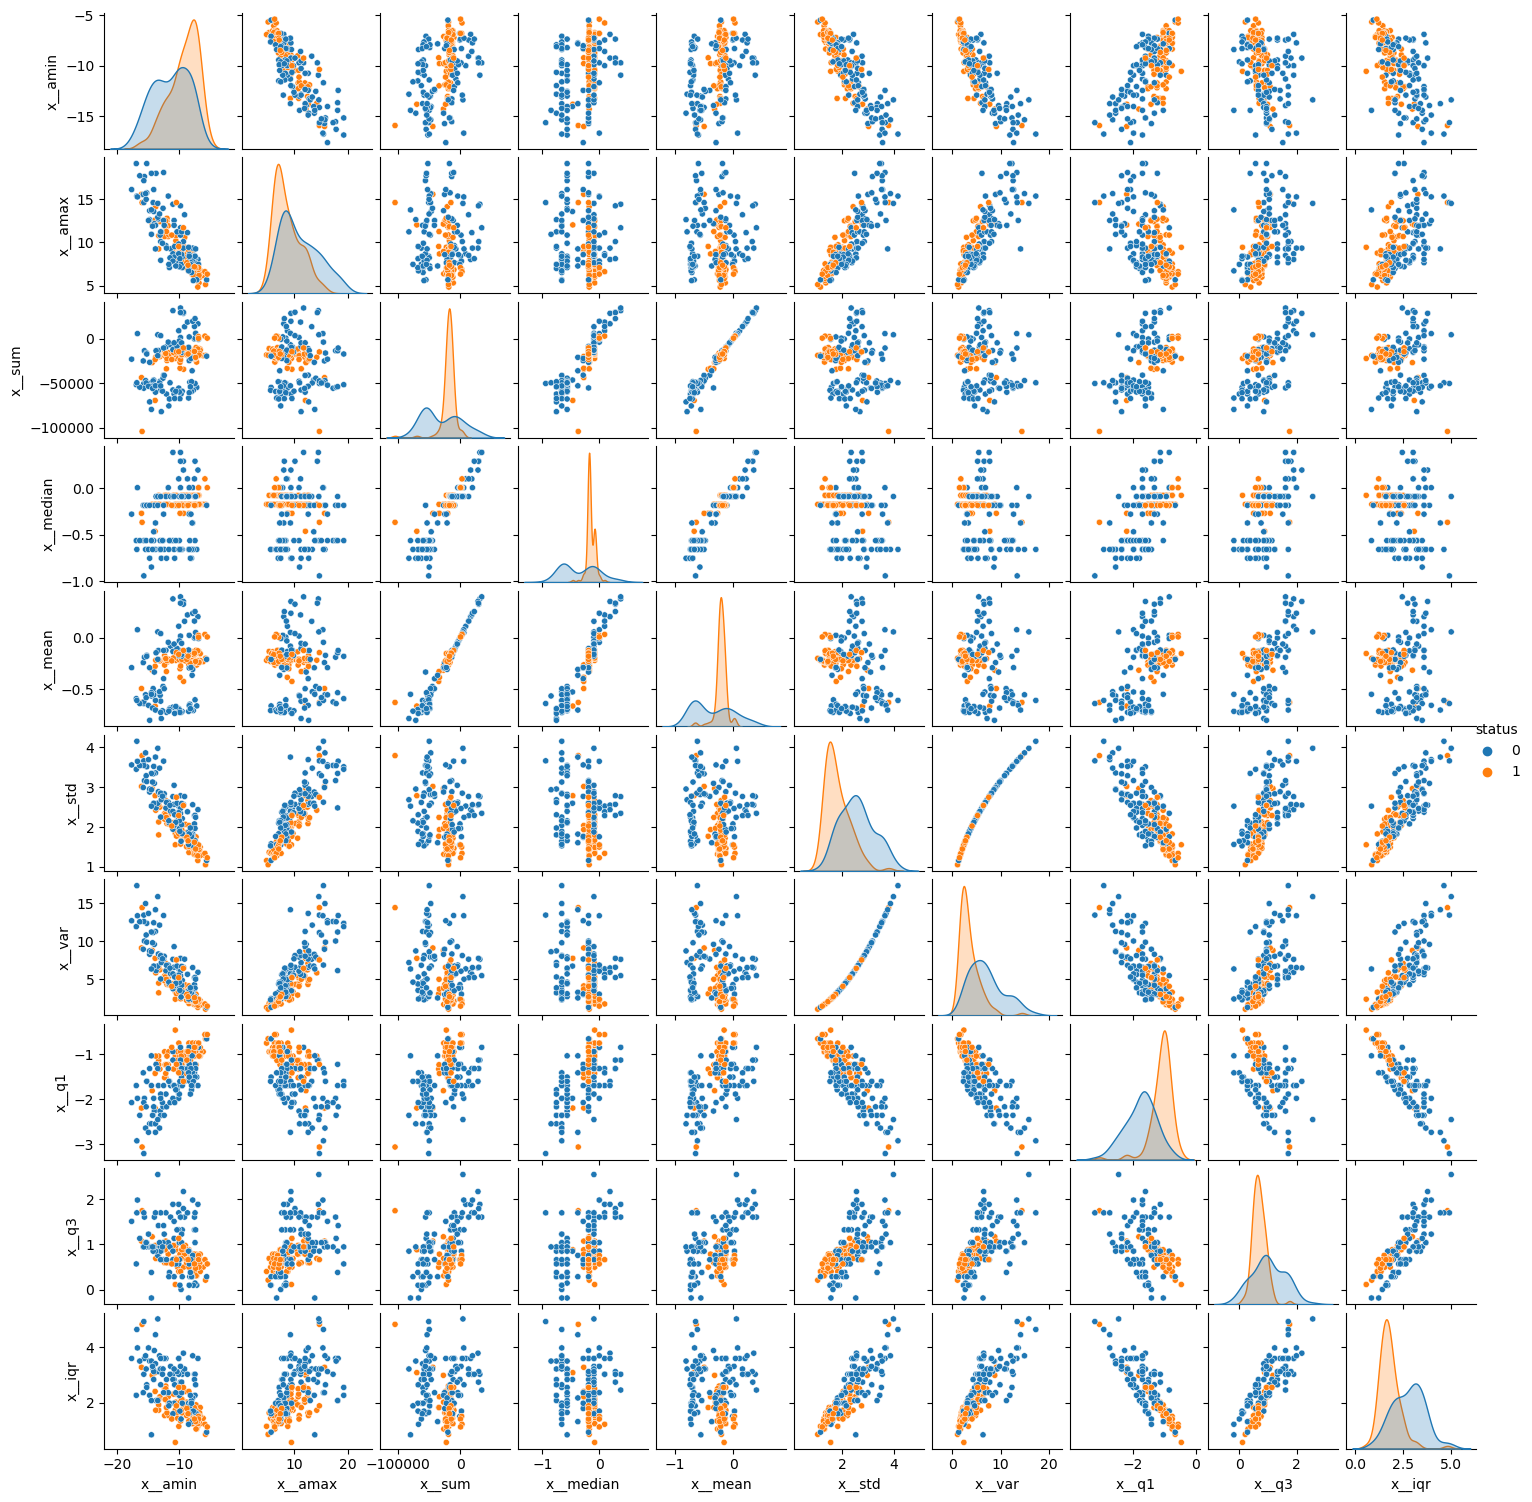

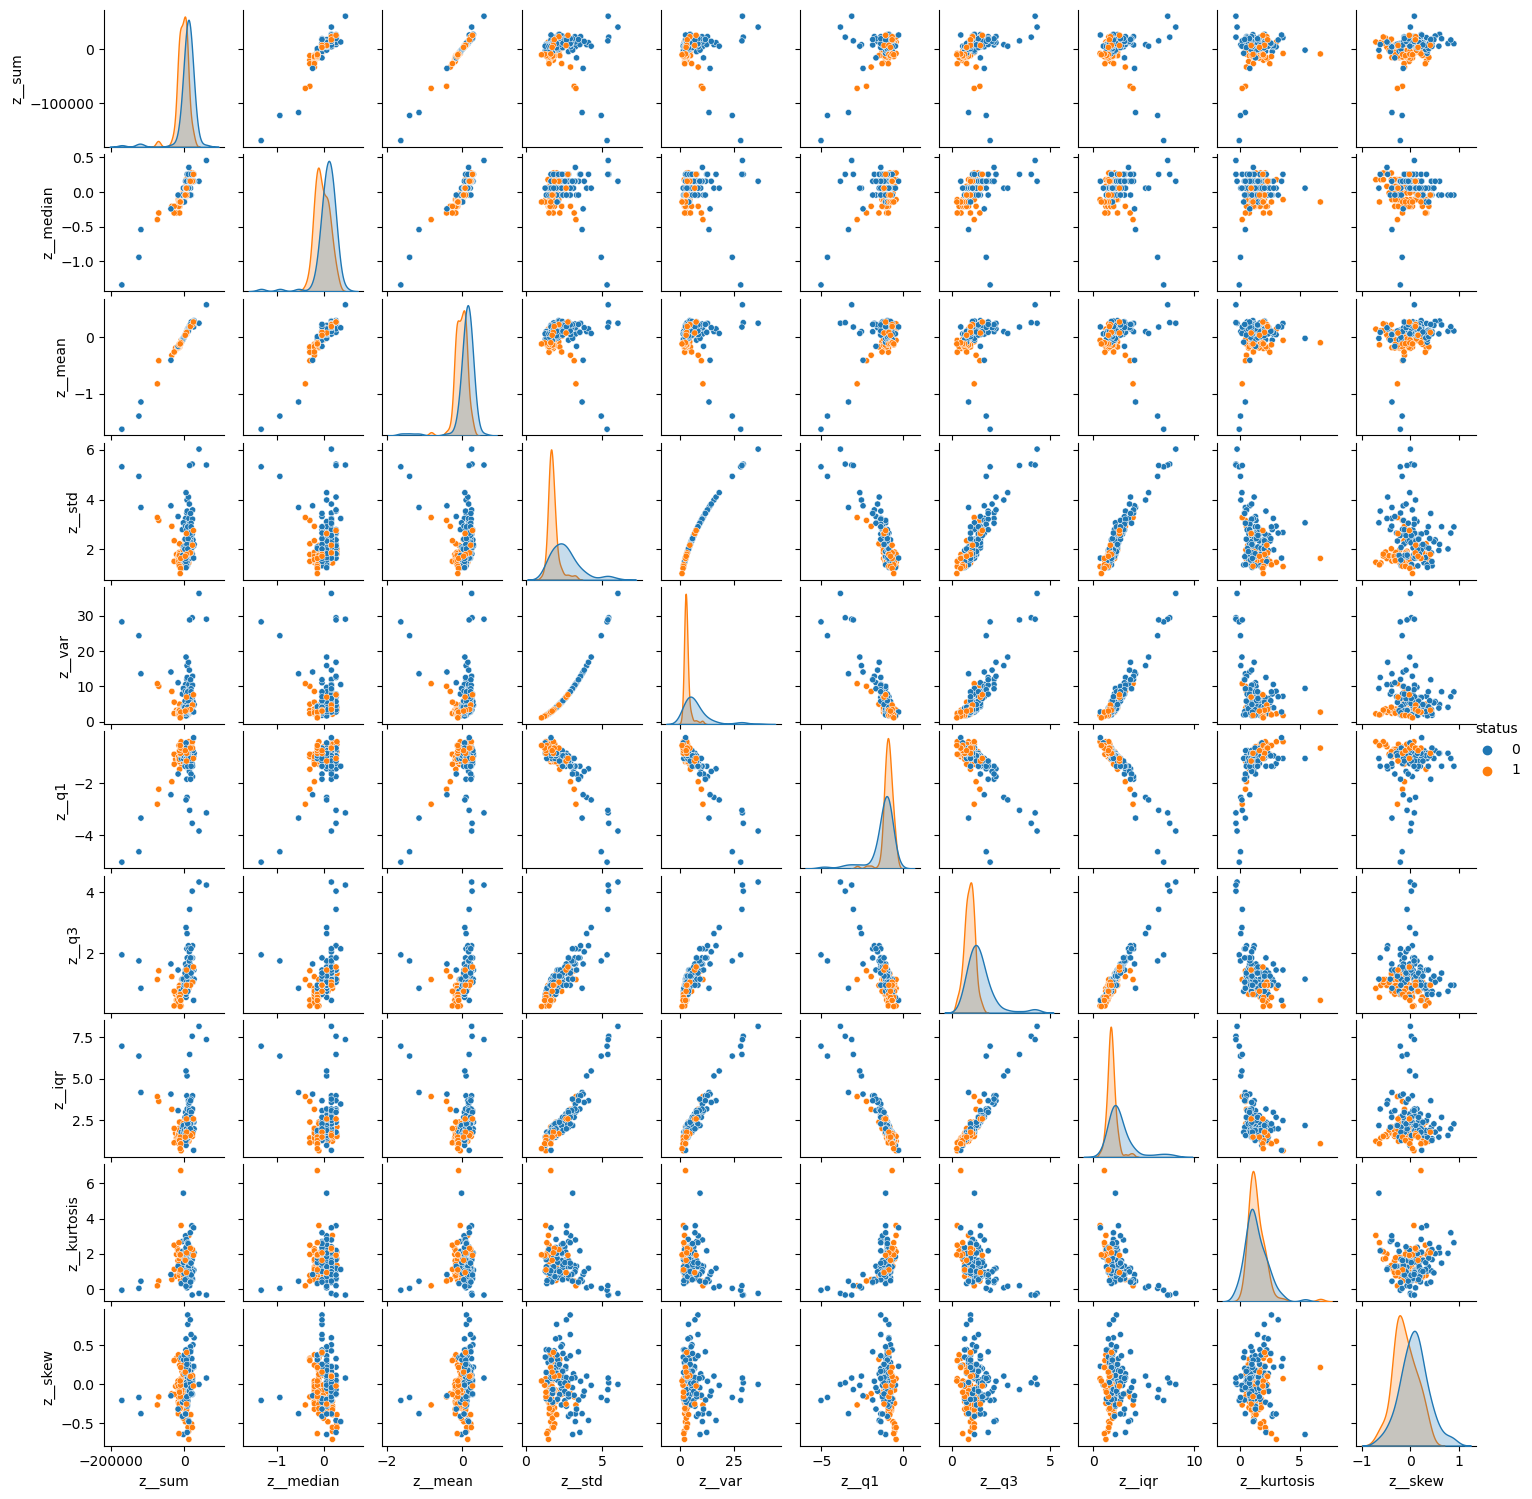

In [25]:
_ = sns.pairplot(data=df_plt, vars = cols[:10], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)
_ = sns.pairplot(data=df_plt, vars = cols[-10:], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

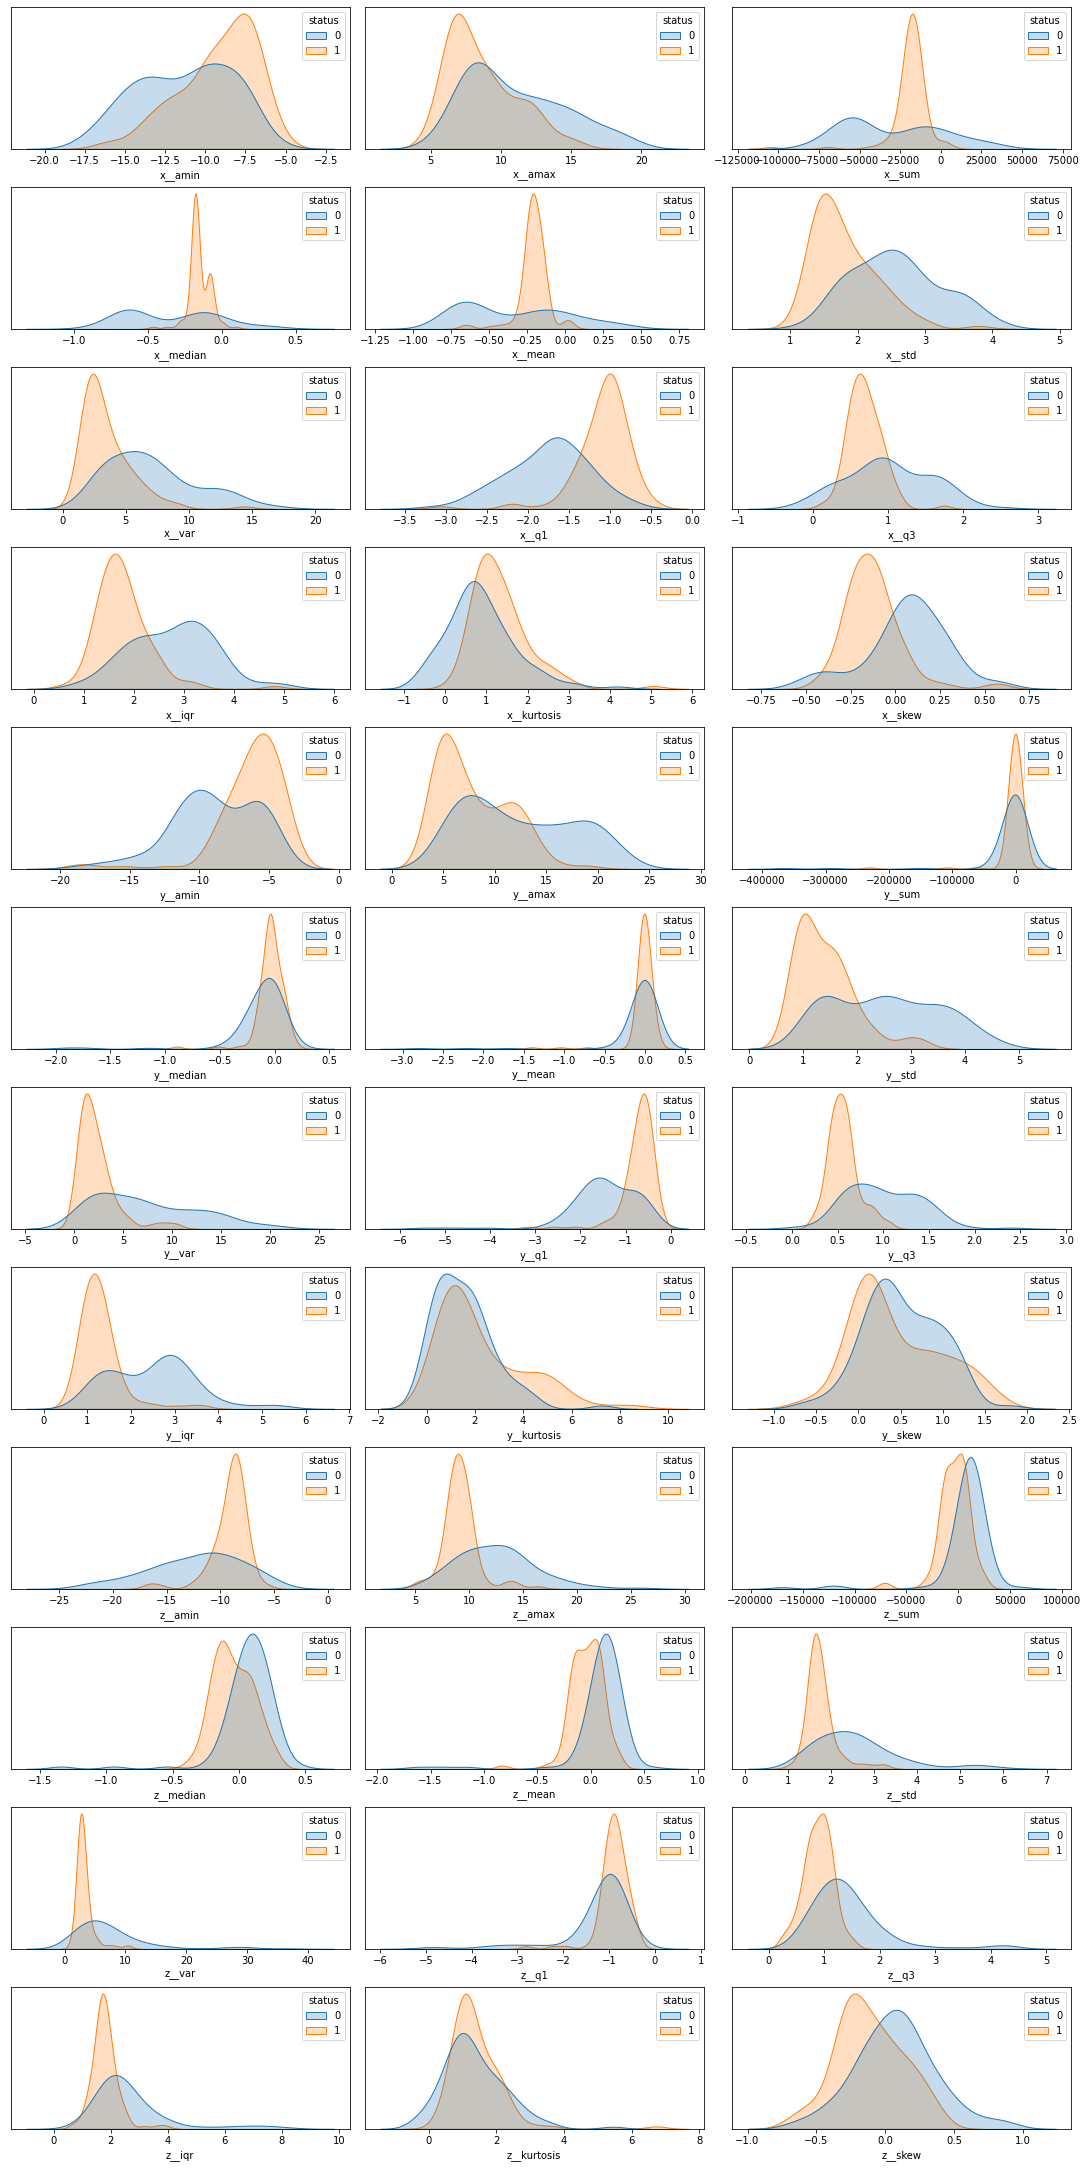

In [17]:
df_plt = df_train
# cols = ['x__amin', 'x__amax', 'x__sum','y__amin', 'y__amax', 'y__sum', 'z__amin', 'z__amax', 'z__sum']
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

axs = f.get_axes(int(len(cols)/3), 3, 1, 2).flat

for ax, col in zip(axs[:len(cols)], cols):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', shade=True)
    # _ = ax.axes.get_xaxis().set_visible(False)
    _ = ax.axes.get_yaxis().set_visible(False)
    # _ = ax.legend().set_visible(False)

In [18]:
df_train.columns
feature_cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

X = df_train[feature_cols]
X.shape
X.head(3)

y = df_train['status']
y.shape
y.head(3)

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__q1', 'x__q3', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__q1', 'y__q3', 'y__iqr',
       'y__kurtosis', 'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median',
       'z__mean', 'z__std', 'z__var', 'z__q1', 'z__q3', 'z__iqr',
       'z__kurtosis', 'z__skew'],
      dtype='object')

(200, 36)

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__q1,x__q3,x__iqr,x__kurtosis,x__skew,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__q1,y__q3,y__iqr,y__kurtosis,y__skew,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__q1,z__q3,z__iqr,z__kurtosis,z__skew
0,-6.716668,5.307868,-10988.070315,-0.079124,-0.134299,1.359987,1.849565,-0.944891,0.690446,1.635337,0.645580,-0.260035,-5.812267,5.638507,-2005.749440,-0.039563,-0.024515,1.090317,1.188792,-0.702004,0.622879,1.324883,0.845721,0.190106,-8.080924,8.244501,-15909.421691,-0.206307,-0.194449,1.503315,2.259956,-1.070594,0.754012,1.824606,0.873858,-0.226021
1,-12.103661,11.753020,-18844.323785,-0.175320,-0.239902,2.477716,6.139077,-1.522068,1.075231,2.597300,1.408079,-0.167536,-8.745936,12.452191,-318.869239,-0.134197,-0.004059,2.376120,5.645946,-1.459080,0.906782,2.365862,1.936212,0.887947,-10.193626,10.357203,-6543.554226,-0.110275,-0.083304,2.156482,4.650413,-1.262658,1.138140,2.400798,0.657898,0.065098
2,-7.678631,6.558420,-12546.141906,-0.079124,-0.136898,1.350739,1.824495,-0.752498,0.498054,1.250552,1.485456,-0.097227,-4.298115,5.259969,5780.428883,0.055072,0.063073,0.822131,0.675900,-0.323466,0.433610,0.757076,2.150199,0.258396,-10.289657,8.244501,12884.241287,0.177821,0.140587,1.480194,2.190974,-0.398371,0.850044,1.248415,3.049378,-0.710093


(200,)

0    1
1    1
2    1
Name: status, dtype: int64

In [21]:
f.to_pkl((X, y), f'data-processed/all_b1_b2.data.pkl')